In [28]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing import image as kp_image
import matplotlib.pyplot as plt
import os

In [29]:
# Configuración inicial
content_weight = 1e3
style_weight = 1e-2
texture_weight = 1e-4  # Puedes ajustar este valor según el efecto deseado

In [30]:
# Función para cargar y procesar imágenes
def load_and_process_image(img_path):
    img = kp_image.load_img(img_path, target_size=(512, 512))
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img, dtype=tf.float32)

In [31]:
# Función para desprocesar imágenes (para visualización)
def deprocess_image(processed_img):
    x = processed_img.copy()
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [32]:
# Función para construir el modelo y seleccionar las capas de estilo y contenido
def get_model():
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content_layers = ['block5_conv2']
    model_outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
    return tf.keras.Model(vgg.input, model_outputs), style_layers, content_layers

In [33]:
# Función para calcular la pérdida de contenido
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

In [34]:
# Función para calcular la pérdida de estilo
def gram_matrix(input_tensor):
    # Asegura que input_tensor tiene 4 dimensiones
    if len(input_tensor.shape) == 3:
        input_tensor = tf.expand_dims(input_tensor, axis=0)

    # Calcula la matriz de Gram
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations


In [35]:
def style_loss(base_style, gram_target):
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

In [36]:
# Cargar y procesar las imágenes
base_dir = os.getcwd() 
content_image_path =  os.path.join(base_dir, 'Contenido.jpg')  # Imagen de contenido
style_image_path = os.path.join(base_dir, 'Estilo.jpeg')       # Imagen de estilo
content_image = load_and_process_image(content_image_path)
style_image = load_and_process_image(style_image_path)

In [37]:
# Cargar el modelo y obtener las capas de contenido y estilo
model, style_layers, content_layers = get_model()

# Extraer las características de estilo de la imagen de estilo
style_outputs = model(style_image)
style_features = [style_layer for style_layer in style_outputs[:len(style_layers)]]

# Extraer las características de contenido de la imagen de contenido
content_outputs = model(content_image)
content_features = [content_layer for content_layer in content_outputs[len(style_layers):]]

In [38]:
# Configura la imagen inicial y el optimizador
init_image = tf.Variable(content_image, dtype=tf.float32)
opt = optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

In [39]:
# Función para calcular los gradientes y la pérdida total
def compute_loss_and_grads(cfg):
    with tf.GradientTape() as tape:
        model_outputs = cfg['model'](cfg['init_image'])
        
        # Separar características de estilo y contenido
        style_output_features = model_outputs[:len(cfg['style_features'])]
        content_output_features = model_outputs[len(cfg['style_features']):]
        
        # Pérdida de estilo
        style_score = 0
        for target_style, comb_style in zip(cfg['style_features'], style_output_features):
            style_score += style_loss(comb_style[0], gram_matrix(target_style))
        style_score *= style_weight
        
        # Pérdida de contenido
        content_score = 0
        for target_content, comb_content in zip(cfg['content_features'], content_output_features):
            content_score += content_loss(comb_content[0], target_content)
        content_score *= content_weight
        
        # Pérdida total
        total_loss = style_score + content_score
    grads = tape.gradient(total_loss, cfg['init_image'])
    return grads, total_loss

In [40]:
# Configuración del diccionario de características y pesos
cfg = {
    'model': model,
    'loss_weights': (content_weight, style_weight, texture_weight),
    'init_image': init_image,
    'content_features': content_features,
    'style_features': style_features
}

Iteration 0: Loss: 3993871872.0
Iteration 100: Loss: 3549896704.0
Iteration 200: Loss: 3154594048.0
Iteration 300: Loss: 2798130688.0
Iteration 400: Loss: 2475136512.0
Iteration 500: Loss: 2183146752.0
Iteration 600: Loss: 1920225152.0
Iteration 700: Loss: 1684704640.0
Iteration 800: Loss: 1474533760.0
Iteration 900: Loss: 1288231552.0


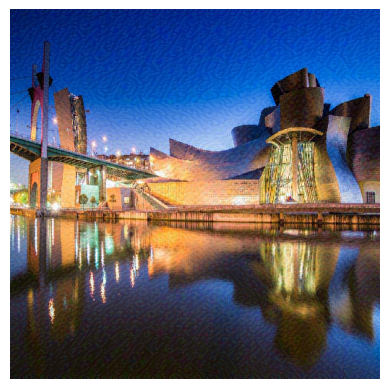

In [41]:
# Número de iteraciones de optimización
num_iterations = 1000

for i in range(num_iterations):
    grads, all_loss = compute_loss_and_grads(cfg)
    opt.apply_gradients([(grads, init_image)])
    
    # Mostrar el progreso de la pérdida
    if i % 100 == 0:
        print(f"Iteration {i}: Loss: {all_loss}")

# Convertir la imagen resultante para visualización
final_img = deprocess_image(init_image.numpy()[0])
plt.imshow(final_img)
plt.axis('off')
plt.show()